# Spin Model for Random Walk

@author wsguo <br>
@date 2017.7

In [5]:
import random
import math
import networkx as nx
from numpy.random import choice
import numpy as np
import matplotlib.pyplot as plot
import json
import simpy as sp
import matplotlib.animation as animation

# Basic function

In [6]:
'''
basic functions 
'''
def print_net(net):
    for row in net:
        print(row)
        
def nlist(net, i):
    '''return a list of I's neighbors in NETWORK, node index starts from 0'''
    neighs = []
    for j in range(len(net)):
        if net[i][j] == 1 and j != i:
            neighs.append(j)
    return neighs
    # degree = len(neighs)
    

def er(n, p):
    '''return an N-node, connected, undirected ER network (adj) with a connection prob P'''
    # an N-node connected network has at least N-1 edges
    if p < 2/n: print('p is too low. Impossible to be connected'); return

    while True:
        er = []
        for i in range(n):
            er.append([0]*n)
        for i in range(n):
            er[i][i] = 0
            for j in range(i+1,n):
                if random.uniform(0,1) < p:
                    er[i][j] = 1
                    er[j][i] = 1
        if is_connected(er): return er
def is_connected(network):
    '''check connectedness with breadth-first search'''
    discovered = [0]; queue = [0]
    while len(queue) > 0:
        curr = queue.pop(0)
        neighs = nlist(network, curr)
        for n in neighs:
            if n not in discovered:
                discovered.append(n)
                queue.append(n)
    return len(discovered) == len(network)

def ws(N, k, p):
    '''return a connected WS network (adj) using networkx''' 
    Graph = nx.connected_watts_strogatz_graph(N, k, p, tries=100, seed=None)
    dic = nx.to_dict_of_lists(Graph)
    ws = []
    for i in range(N):
        ws.append([0]*N)
    for i in dic:
        ws[i][i] = 0
        for j in dic[i] :
            ws[i][j] = 1
    return ws

def erm(N, m):
    '''return a connected WS network (adj) using snap''' 
    for i in range(200):
        Graph = nx.gnm_random_graph(N,m)
        if nx.is_connected(Graph):
            break
        elif i == 199:
            print ('ER connected generator exceed limit')
    dic = nx.to_dict_of_lists(Graph)
    er = []
    for i in range(N):
        er.append([0]*N)
    for i in dic:
        er[i][i] = 0
        for j in dic[i] :
            er[i][j] = 1
    return er


# Graph Visualization

In [14]:
#The network is an adjacency matrix, as is used through out this project. 

#The states is a list of coloring characters in {'r','b'}, corresponding to the coloring of nodes.

#Please make sure the ith element in the states corresponds to the ith row in the network.
from networkx.drawing.layout import random_layout
from networkx.drawing.layout import spring_layout
from networkx.drawing.layout import circular_layout

class network_evolution_recorder:
    
    def __init__(self):
        self.network_frames=[]
        self.states_frames=[]
        self.special_nodes_frames=[]
        
    def update(self,network=None,states=None,specialNodes=None):
        if(specialNodes==None):
            self.special_nodes_frames.append(None)
        else:
            self.special_nodes_frames.append(specialNodes[:])
    
        try:
            if(network==None):
                if(len(self.network_frames)==0):
                    raise Exception('Update none on a empty recorder')
                network=self.network_frames[len(self.network_frames)-1]  #If no new network is passed in, 
                                                               #the new frame should be the same as the last one.
        except Exception as inst:
            print(inst)
            return;
       
        self.network_frames.append(network[:])
       
        if(states==None):
            if(len(self.states_frames)==0):
                self.states_frames.append(None)
                return;
            else:
                states=self.states_frames[len(self.states_frames)-1]
                if(states==None):
                    self.states_frames.append(None)
                    return;
                else:
                    self.states_frames.append(states[:])
        else:
            self.states_frames.append(states[:])
        
        

    def draw_current_network(self):
        
        curr_network_frame=self.network_frames[len(self.network_frames)-1]
        curr_states_frame=self.states_frames[len(self.states_frames)-1]
        
        vis_graph=nx.from_numpy_matrix(np.array(curr_network_frame))
#         layout=spring_layout(vis_graph)
        layout=circular_layout(vis_graph)
        
        #If some special nodes is currently updated, 
        size_list=np.array([])
        if(len(self.special_nodes_frames)>0 and self.special_nodes_frames[len(self.special_nodes_frames)-1]!=None):
            size_list=np.full((1,len(curr_network_frame)),300).ravel()
            for s in self.special_nodes_frames[len(self.special_nodes_frames)-1]:
                size_list[s]=500
        
        if(size_list.size==0):
            nx.draw_networkx(vis_graph,with_labels=True,font_weight='bold',node_color=curr_states_frame,pos=layout)
        else:
            nx.draw_networkx(vis_graph,with_labels=True,font_weight='bold',node_color=curr_states_frame,pos=layout,node_size=size_list)
        plot.show()
        
            
        
        
    def play_animation(self):
        
        if (len(self.network_frames)==0 or len(self.states_frames)==0):
            print("No frames to animate.")
            return;
        
        if (len(self.network_frames)!= len(self.states_frames)==0):
            print("Number of network frames does not match number of states frames.")
            return;      
        
        vis_graph=nx.from_numpy_matrix(np.array(self.network_frames[0]))
#         layout=spring_layout(vis_graph)
        layout=circular_layout(vis_graph)
    
        fig2=plot.figure()
       
        artists=[]
        
        curr_network_frame=None
        curr_states_frame=None
#         print(1)
        for i in range(0,len(self.network_frames)):
            try:
#                 print(1)
                curr_network_frame=self.network_frames[i]
                curr_states_frame=self.states_frames[i]
#                 print(2)
                if(curr_network_frame==None):
                    raise Exception('A Null frame is encountered')
            except Exception as inst:
                print(inst)
                return
            
            vis_graph=nx.from_numpy_matrix(np.array(curr_network_frame))
            
            #If some special nodes is currently updated, 
            size_list=np.full((1,len(curr_network_frame)),300).ravel()
            if(len(self.special_nodes_frames)>0 and self.special_nodes_frames[i]!=None):
                for s in self.special_nodes_frames[i]:
                    size_list[s]=1200

            nodes=nx.draw_networkx_nodes(vis_graph,with_labels=True,font_weight='bold',node_color=curr_states_frame,pos=layout,node_size=size_list,edgecolors='k')
#             print(3)
            edges=nx.draw_networkx_edges(vis_graph,with_labels=True,font_weight='bold',node_color=curr_states_frame,pos=layout,node_size=size_list)
            
            labels=nx.draw_networkx_labels(vis_graph,with_labels=True,font_weight='bold',node_color=curr_states_frame,pos=layout,node_size=size_list)
#             print(4)
            artists.append([nodes,edges])
            
        im_ani = animation.ArtistAnimation(fig2, artists, interval=1000, repeat_delay=10,
                                   blit=True)
        
        im_ani.save("ani.mp4")
#         im_ani.to_jshtml()
#         plot.show()

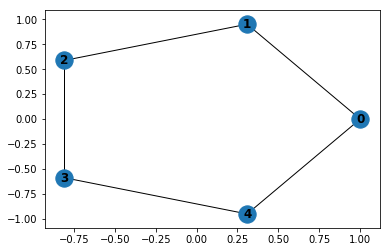

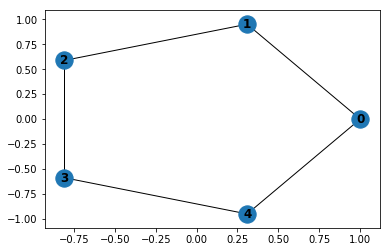

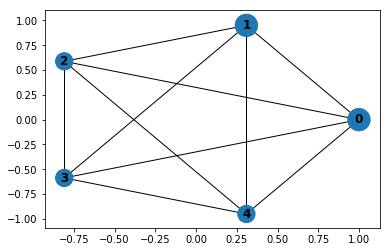

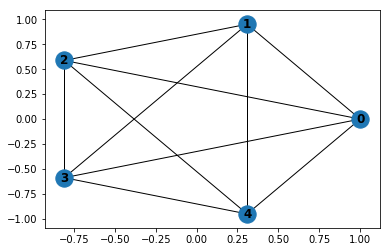

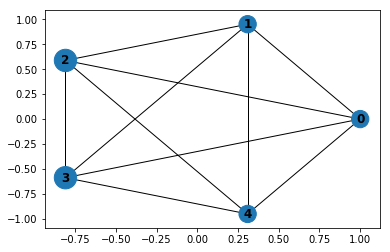

In [8]:
def coloring_test():
    nv=network_evolution_recorder()
    nv.update(network=ws(5,2,0.1),states=None)
    nv.draw_current_network()
    nv.update(network=ws(5,3,0.1),states=None)
    nv.draw_current_network()
    nw=ws(5,4,0.1)
    nv.update(network=nw,states=None,specialNodes=[1,2])
    nv.draw_current_network()
    
    nv.update(network=nw,states=None)
    nv.draw_current_network()
    nv.update(network=nw,states=None,specialNodes=[3,4])
    nv.draw_current_network()
    nv.update(network=nw,states=None)
#     nv.draw_current_network()
#     nv.draw_network_coloring()
#     nv.draw_network_coloring()
#     nv.draw_network_coloring()
    nv.play_animation()
    


coloring_test()
#     env.run(until=4)

# Walker function

In [9]:
def rwalker(init, step, network):
    '''
    random walker
    '''
    if step == 0:
        return []
    curr = init
    neighs = nlist(network, curr)
    succ = random.choice(neighs)
    path = []
    path.append(succ)
    for i in range(step-1):
        neighs = nlist(network, succ)
        succ = random.choice(neighs)
        path.append(succ)
    return path     

In [10]:
def cover(network, state):
    red = 0
    blue = 0
    for i in range(len(network)):
        if state[i] == 'w':
            return False
            break
        elif state[i] == 'r':
            red = red + 1
        else:
            blue = blue + 1
    print ("num of red and blue")
    print [red,blue]
    return True     

In [11]:
'''
Strong relupsion: beta -> infrun101errun101errun101er
'''
def twoSpinWalker (Network):
    numOfNodes = len(Network)
    time = 0
    #first passage time list for all sites
    plist = ['inf'] * numOfNodes
    #number of unvisited sites
    un = numOfNodes - 2
    #unvisited is white
    states = ['w'] * numOfNodes
    starts = random.sample(range(numOfNodes),2)
    starta = starts[0]
    startb = starts[1]
    #starting points first passage time is 0
    plist[starta] = 0
    plist[startb] = 0
    # a is red, b is blue
    states[starta] = 'r'
    states[startb] = 'b'
    def twalker(init, selfColor):
        '''
        spin model random walker, avoid another walker
        one step
        return end position and update end position color
        
        '''
        #whether the walker revisit a visited site
        rev = True
        neigh = nlist(Network,init)
        ends = []
        for n in neigh:
            if states[n] == 'w' or states[n] == selfColor:
                ends.append(n)
        #if every neighbor is other walker color, randomly choose one
        if ends == []:
            end = random.choice(neigh)
            states[end] = selfColor
            return [end, rev]
        #randomly choose from availble sites
        else:
            end = random.choice(ends)
            if states[end] == 'w':
                states[end] = selfColor
                plist[end] = time
                #whether the walker revisit a visited site
                rev = False 
            return [end, rev]
    def swalker(init, selfColor):
        '''
        spin model random walker, avoid another walker
        one step
        return end position and update end position color
        
        '''
        #whether the walker revisit a visited site
        rev = True
        neigh = nlist(Network,init)
        ends = []
        for n in neigh:
            if states[n] == 'w' or states[n] == selfColor:
                ends.append(n)
        #if every neighbor is other walker color, randomly choose one
        if ends == []:
            end = random.choice(neigh)
            states[end] = selfColor
            return [end, rev]
        #randomly choose from availble sites
        else:
            end = random.choice(ends)
            if states[end] == 'w':
                states[end] = selfColor
                plist[end] = time
                #whether the walker revisit a visited site
                rev = False 
            return [end, rev]
    while un != 0:
        time = time + 1
        if random.uniform(0,1) < 0.5:
            r1 = swalker(starta,'r')
            starta = r1[0]
            if r1[1] == False:
                un = un - 1
            r2 = swalker(startb,'b')
            startb = r2[0]
            if r2[1] == False:
                un = un - 1
        else: 
            r2 = swalker(startb,'b')
            startb = r2[0]
            if r2[1] == False:
                un = un - 1
            r1 = swalker(starta,'r')
            starta = r1[0]
            if r1[1] == False:
                un = un - 1
            
    #isCover = cover(Network, states)
    #print 'isCover:'
    #print isCover
    #plist: first passage time list 
    m = sum(plist) / float(len(plist))
    #return time and global mean first passage time
    #tpdic = {'time':time, 'g':m}
    return [time, m]
            

In [15]:
'''
with beta param
'''
def twoSpinWalkerBeta (Network, beta):
    numOfNodes = len(Network)
    time = 0
    #first passage time list for all sites
    plist = ['inf'] * numOfNodes
    #number of unvisited sites
    un = numOfNodes - 2
    #unvisited is white
    states = ['w'] * numOfNodes
    starts = random.sample(range(numOfNodes),2)
    starta = starts[0]
    startb = starts[1]
    #starting points first passage time is 0
    plist[starta] = 0
    plist[startb] = 0
    # a is red, b is blue
    states[starta] = 'r'
    states[startb] = 'b'
    def swalker(init, selfColor):
        '''
        spin model random walker, avoid another walker, 
        prob to opponent: po 
        prob to self or white (good): pg
        one step
        return end position and update end position color
        
        '''
        #whether the walker revisit a visited site
        rev = True
        neigh = nlist(Network,init)
        #ki: degree of init site
        ki = len(neigh)
        ends = []
        for n in neigh:
            if states[n] == 'w' or states[n] == selfColor:
                ends.append(n)
        #ni: number of opponent color sites
        ni = ki - len(ends)
        #if every neighbor is other walker color, randomly choose one
        if ends == []:
            end = random.choice(neigh)
            states[end] = selfColor
            return [end, rev]
        #if every neighbor is not other walker color (all w or self)
        elif ni == 0:
            end = random.choice(neigh)
            if states[end] == 'w':
                states[end] = selfColor
                plist[end] = time
                #whether the walker revisit a visited site
                rev = False 
            return [end, rev]
        
        #general case: choose from all neighbor sites with po/pg
        else:
            po = float(math.exp((-1)* beta))/ki
            pg = float(1 - ni * po)/(ki - ni)
            problist = [po] * ki
            for site in ends:
                siteIndex = neigh.index(site)
                problist[siteIndex] = pg
            #round a bit to make total prob = 1, caused by floating point rounding
            problist[0] = 1 - sum(problist[1:])
            end = list(choice(neigh, 1, p = problist))[0]
            if states[end] == 'w':
                states[end] = selfColor
                plist[end] = time
                #whether the walker revisit a visited site
                rev = False 

            return [end, rev]
        
        
    vis=network_evolution_recorder()        
    vis.update(network=Network,states=states,specialNodes=[starta,startb])#Initialize network recorder.
#     vis.draw_current_network()
    #Start of simulation main loop
    while un != 0:
         
        time = time + 1
        
        if random.uniform(0,1) < 0.5:
            r1 = swalker(starta,'r')
            starta = r1[0]
            if r1[1] == False:
                un = un - 1
            r2 = swalker(startb,'b')
            startb = r2[0]
            if r2[1] == False:
                un = un - 1
        else: 
            r2 = swalker(startb,'b')
            startb = r2[0]
            if r2[1] == False:
                un = un - 1
            r1 = swalker(starta,'r')
            starta = r1[0]
            if r1[1] == False:
                un = un - 1     

        vis.update(network=None,states=states,specialNodes=[starta,startb]) 
        
#         vis.draw_current_network()
   
        
    #End of simulation main loop
    
    #isCover = cover(Network, states)
    #print 'isCover:'
    #print isCover
    #plist: first passage time list 
    m = sum(plist) / float(len(plist))
    #return time and global mean first passage time
    #tpdic = {'time':time, 'g':m}
    return vis,states,[time, m]
            

In [16]:
def sw_beta_test():
    vis,dum,dum2=twoSpinWalkerBeta(ws(10,5,0.4),0.4)
    vis.play_animation()
sw_beta_test()

# Avg Simulation

In [ ]:
'''
ER network
@return MCT and GMFPT
'''
def run30erB101(p):
    #beta value
    betaValue = 0
    tlist = []  #mean cover time
    plist = []  #global mean first passage time
    while betaValue < 5:
        gt = []
        gp = []
        for i in range(30):
            g1 = er(101,p)
            gt1 = []
            gp1 = []
            for j in range(100):   
                result = twoSpinWalkerBeta(g1, betaValue)
                gt1.append(result[0])
                gp1.append(result[1])
            #average result over one network
            gt1 = sum(gt1) / float(len(gt1))
            gp1 = sum(gp1) / float(len(gp1))
            gt.append(gt1)
            gp.append(gp1)
        gt = sum(gt) / float(len(gt))
        gp = sum(gp) / float(len(gp))
        tlist.append(gt)
        plist.append(gp)
        betaValue = betaValue + 0.1
        print ("beta value")
        print (betaValue)
    return tlist + plist

In [ ]:
'''
ws network
@return MCT and GMFPT
'''
def run30wsB101(b1,k1):
    #rewiring prob is b1
    #avg degree is k1
    #beta value
    betaValue = 0.1
    tlist = []  #mean cover time
    plist = []  #global mean first passage time
    while betaValue < 4:
        print ('run beta value')
        print (betaValue)
        gt = []
        gp = []
        for i in range(30):
            g1 = ws(101, k1, b1)
            gt1 = []
            gp1 = []
            for j in range(100):   
                result = twoSpinWalkerBeta(g1, betaValue)
                gt1.append(result[0])
                gp1.append(result[1])
            #average result over one network
            gt1 = sum(gt1) / float(len(gt1))
            gp1 = sum(gp1) / float(len(gp1))
            gt.append(gt1)
            gp.append(gp1)
        gt = sum(gt) / float(len(gt))
        gp = sum(gp) / float(len(gp))
        tlist.append(gt)
        plist.append(gp)
        betaValue = betaValue + 0.1
        print ("incre beta value")
        print (betaValue)
    return tlist + plist

In [ ]:
'''
focus on beta_min
'''
#return beta_min + tlist+ plist
def run30wsB101min(b1,k1):
    #b1:rewiring prob
    #k1:beta value
    betaValue = 1.7
    tlist = []  #mean cover time
    plist = []  #global mean first passage time
    while betaValue < 3.73:
        print ('run beta value')
        print (betaValue)
        gt = []
        gp = []
        for i in range(30):
            g1 = ws(101, k1, b1)
            gt1 = []
            gp1 = []
            for j in range(100):   
                result = twoSpinWalkerBeta(g1, betaValue)
                gt1.append(result[0])
                gp1.append(result[1])
            #average result over one network
            gt1 = sum(gt1) / float(len(gt1))
            gp1 = sum(gp1) / float(len(gp1))
            gt.append(gt1)
            gp.append(gp1)
        gt = sum(gt) / float(len(gt))
        gp = sum(gp) / float(len(gp))
        tlist.append(gt)
        plist.append(gp)
        betaValue = betaValue + 0.05
        print ("incre beta value")
        print (betaValue)
        #average MCT ever five nearest beta value
        tavglist = []
        for i in range(41):
            if i <= 2:
                tavg = sum(tlist[:5])/float(5)
            elif i >= 38:
                tavg = sum(tlist[36:41])/float(5)
            else:
                tavg = sum(tlist[i-2:i+3])/float(5)
            tavglist.append(tavg)
        min_index = tavglist.index(min(tavglist))
        beta_min = 1.7 + float(0.05) * min_index
    return [beta_min] + tlist + plist